<a href="https://www.kaggle.com/code/sheemamasood/birdclef-2025-data-prepartion?scriptVersionId=245829306" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🐦 BirdCLEF 2025 - Audio Preprocessing Cleaning the Data

This notebook is focused on preparing the BirdCLEF 2025 dataset for training an audio classification model. The workflow includes loading and cleaning data, chunking audio into 10-second segments, filtering out human voice using a VAD model.

## 🔗 BirdCLEF 2025 - Project Notebook Links

Here are the different stages of my BirdCLEF 2025 pipeline, organized by functionality:

### 📊 Data Preparation
- [BirdCLEF 2025 - Data Preparation](https://www.kaggle.com/code/sheemamasood/birdclef-2025-data-prepartion)

### 🎛️ Mel Spectrogram Generation
- [BirdCLEF 2025 - Mel Generation](https://www.kaggle.com/code/sheemamasood/birdclef2025-mel-generation)

### 🏷️ Pseudo Labelling for SSL
- [BirdCLEF 2025 - Pseudo Labelling for SSL](https://www.kaggle.com/code/sheemamasood/birdclef2025-psedolabelling-for-ssl)

### 🧠 Model Training
- [BirdCLEF 2025 - Model Training (Phase 1)](https://www.kaggle.com/code/sheemamasood/birdclef2025-model-training-phase1)

### 📦 Inference & Submissions
- [BirdCLEF 2025 - Submissions](https://www.kaggle.com/code/sheemamasood/birdclef2025-submissions)


###  Import Required Libraries

In [1]:
# Basic utilities
import os
import math
import time
import random
import gc 
import logging
import warnings
from pathlib import Path
import librosa.display
import matplotlib.pyplot as plt
import torch
import torchaudio


# Data handling
import numpy as np
import pandas as pd

# Visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  

print("all libraries imported in the environment")

all libraries imported in the environment


## Check Librosa Library

In [2]:
# Audio processing
import librosa
print(f"librosa version : {librosa.__version__}")
print(f"librosa files :{librosa.__file__}")

y = np.random.randn(32000)
D = librosa.stft(y, hop_length=512)
D_stretched = librosa.phase_vocoder(D, rate=1.1, hop_length=512)
print(D_stretched.shape)

librosa version : 0.11.0
librosa files :/usr/local/lib/python3.11/dist-packages/librosa/__init__.py
(1025, 58)


## Define Configuration Class

In [3]:
class Config:
    # Audio settings
    FS = 32000  # Sampling rate (audio)

    # Mel spectrogram parameters (for converting audio to image)
    N_FFT = 1024       # FFT window size
    HOP_LENGTH = 512   # Step size for each frame
    N_MELS = 128       # Number of mel bands
    FMIN = 50          # Minimum Mel frequency
    FMAX = 14000       # Maximum Mel frequency

    # Parameters for audio duration and spectrogram size
    TARGET_DURATION = 10.0  # Length of each audio (in seconds)
    TARGET_SHAPE = (3, 256, 256)  # Size of the spectrogram image

    # No limit on the number of samples during training (full dataset)
    N_MAX = None  

    # flag for training mode
    TRAINING_MODE = True  
    
    # Additional training-specific configurations
    EPOCHS = 10  
    BATCH_SIZE = 32  
    LEARNING_RATE = 0.001  

# Create the config object
config = Config()

##  Load BirdCLEF 2025 Dataset

In [4]:
# Root path where all files and folders are stored
DATA_ROOT = '/kaggle/input/birdclef-2025'

# Load CSVs
train_df = pd.read_csv(os.path.join(DATA_ROOT, 'train.csv'))
taxonomy_df = pd.read_csv(os.path.join(DATA_ROOT, 'taxonomy.csv'))
location_df = pd.read_csv(os.path.join(DATA_ROOT, 'recording_location.txt'), delimiter='\t')
sample_submission = pd.read_csv(os.path.join(DATA_ROOT, 'sample_submission.csv'))
working_df = pd.read_csv("/kaggle/input/melspectrogramofbirdclef-2025/working_df.csv")


print(f"✅ Loaded train_df: {train_df.shape}")
print(f"✅ Loaded taxonomy_df: {taxonomy_df.shape}")
print(f"✅ Loaded location_df: {location_df.shape}")
print(f"✅ Loaded sample_submission: {sample_submission.shape}")
print(f"✅ Loaded working_df: {working_df.shape}")


✅ Loaded train_df: (28564, 13)
✅ Loaded taxonomy_df: (206, 5)
✅ Loaded location_df: (4, 1)
✅ Loaded sample_submission: (3, 207)
✅ Loaded working_df: (28564, 10)


##  Data Inspection

In [5]:
print("="*50)
print(f"🗺️  Working_df Shape: {working_df.shape}")
print("="*50)

print("="*50)
print("\n📊 working Data Types:")
print(working_df.info())
print("="*50)


#  Missing Values Check
print("="*50)
print("\n❌ Missing Values in Working Data:")
print(working_df.isnull().sum())
print("="*50)

print("="*50)
print("\n🔹 Sample Rows from working Data:")
display(working_df.sample(5))
print("="*50)


🗺️  Working_df Shape: (28564, 10)

📊 working Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28564 entries, 0 to 28563
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     28564 non-null  object 
 1   rating            28564 non-null  float64
 2   filename          28564 non-null  object 
 3   target            28564 non-null  int64  
 4   filepath          28564 non-null  object 
 5   samplename        28564 non-null  object 
 6   class             28564 non-null  object 
 7   secondary_labels  28564 non-null  object 
 8   secondary_target  28564 non-null  object 
 9   duration          28564 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 2.2+ MB
None

❌ Missing Values in Working Data:
primary_label       0
rating              0
filename            0
target              0
filepath            0
samplename          0
class               0
secondary_labe

,primary_label,rating,filename,target,filepath,samplename,class,secondary_labels,secondary_target,duration
21921,strher,3.0,strher/XC549360.ogg,174,/kaggle/input/birdclef-2025/train_audio/strher...,strher-XC549360,Aves,[''],[0],31.536000
26765,yebsee1,3.0,yebsee1/XC424592.ogg,197,/kaggle/input/birdclef-2025/train_audio/yebsee...,yebsee1-XC424592,Aves,[''],[0],5.208000
27452,yehcar1,5.0,yehcar1/XC664789.ogg,201,/kaggle/input/birdclef-2025/train_audio/yehcar...,yehcar1-XC664789,Aves,[''],[0],9.743688
13777,olipic1,3.0,olipic1/XC807603.ogg,128,/kaggle/input/birdclef-2025/train_audio/olipic...,olipic1-XC807603,Aves,[''],[0],35.709000
7081,cocwoo1,4.0,cocwoo1/XC954896.ogg,94,/kaggle/input/birdclef-2025/train_audio/cocwoo...,cocwoo1-XC954896,Aves,[''],[0],4.571438


## Save Master Label List

In [6]:
# Ek bar run karo:
import pickle
all_labels = sorted(working_df['primary_label'].unique())  # full_df = poora data
with open("master_label_list.pkl", "wb") as f:
    pickle.dump(all_labels, f)

## ✂️ Audio Chunking Function

We define the `split_audio_into_10sec_chunks()` function, which performs the following tasks:

- Loads each audio file from the dataset
- Splits the audio into non-overlapping 10-second chunks
- Stores metadata for each chunk (such as start time, duration, label, and file path) in a new DataFrame

This chunk-level data allows us to:

- Standardize the audio input length for training deep learning models
- Apply voice detection and other filtering techniques at a finer granularity

The chunked metadata plays a crucial role in improving data quality and model robustness.

---


In [7]:
def split_audio_into_10sec_chunks(df, sample_rate=config.FS, chunk_len_sec=10):
    chunk_records = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        y, sr = librosa.load(row['filepath'], sr=sample_rate)
        duration_sec = librosa.get_duration(y=y, sr=sr)

        samples_per_chunk = int(chunk_len_sec * sr)
        num_chunks = int(duration_sec // chunk_len_sec)

        for i in range(num_chunks):
            start_sample = i * samples_per_chunk
            end_sample = (i + 1) * samples_per_chunk

            chunk_records.append({
                'chunk_id': f"{row['samplename']}_chunk{i}",
                'primary_label': row['primary_label'],
                'rating': row['rating'],
                'filename': row['filename'],
                'target': row['target'],
                'filepath': row['filepath'],
                'samplename': row['samplename'],
                'class': row['class'],
                'secondary_labels': row['secondary_labels'],
                'secondary_target': row['secondary_target'],
                'duration': row['duration'],
                'start_sec': i * chunk_len_sec,
                'end_sec': (i + 1) * chunk_len_sec,
                'start_sample': start_sample,
                'end_sample': end_sample
            })

    chunked_df = pd.DataFrame(chunk_records)
    return chunked_df



  0%|          | 0/28564 [00:00<?, ?it/s]

CSV saved successfully!
Total 10-sec chunks: 86915
primary_label
compau     2856
grekis     2492
roahaw     2463
whtdov     2355
laufal1    2311
           ... 
65419         3
66016         2
548639        2
42113         1
42087         1
Name: count, Length: 202, dtype: int64
Average chunks per file: 3.95


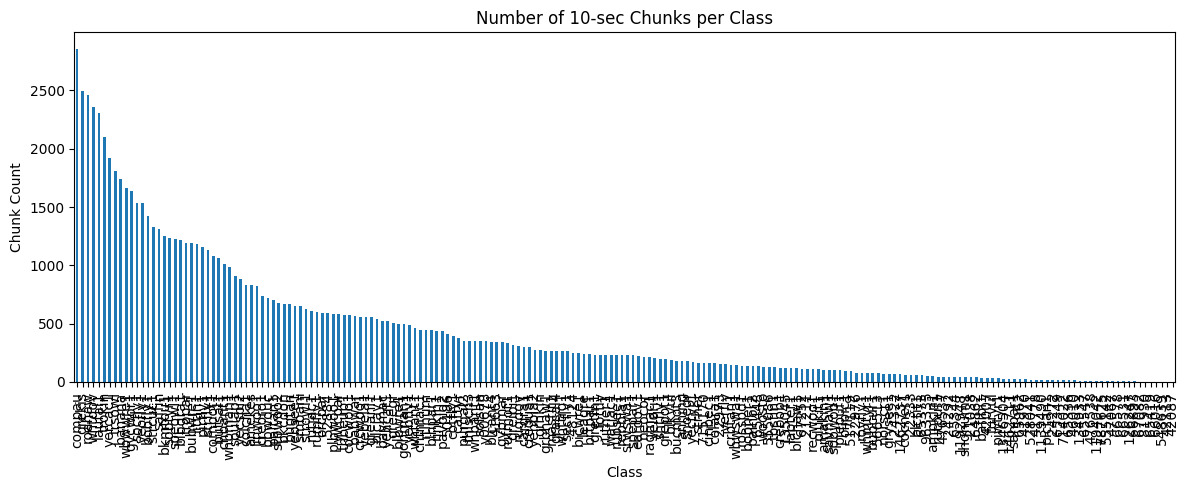

In [8]:
# Split all dataset into 10 sec chunks
chunked_df = split_audio_into_10sec_chunks(working_df)

chunked_df.to_csv("10_sec_chunked_dataset.csv", index=False)
print("CSV saved successfully!")

#Total Chunks Created
print(f"Total 10-sec chunks: {len(chunked_df)}")

#Chunks per Class (Label)
print(chunked_df['primary_label'].value_counts())

#Average Chunks per File
avg_chunks = chunked_df.groupby("filename").size().mean()
print(f"Average chunks per file: {avg_chunks:.2f}")

#Histogram Plot

chunked_df['primary_label'].value_counts().plot(kind='bar', figsize=(12, 5))
plt.title("Number of 10-sec Chunks per Class")
plt.xlabel("Class")
plt.ylabel("Chunk Count")
plt.tight_layout()
plt.savefig("Number of 10-sec Chunks per Class.png")
plt.show()

## Loading train_soundscapes for splitting into 10 sec chunkes for training

In [9]:
import os
import librosa
import pandas as pd
from tqdm import tqdm

def split_soundscape_files_into_chunks(folder_path, sample_rate=config.FS, chunk_len_sec=10):
    soundscape_files = [f for f in os.listdir(folder_path) if f.endswith('.ogg')]
    chunk_records = []

    # tqdm for progress bar (same as your function)
    for file in tqdm(soundscape_files, desc="Processing soundscapes"):
        file_path = os.path.join(folder_path, file)
        try:
            y, sr = librosa.load(file_path, sr=sample_rate)
            duration_sec = librosa.get_duration(y=y, sr=sr)
            samples_per_chunk = int(chunk_len_sec * sr)
            num_chunks = int(duration_sec // chunk_len_sec)

            samplename = file.replace(".ogg", "")

            for i in range(num_chunks):
                start_sample = i * samples_per_chunk
                end_sample = (i + 1) * samples_per_chunk

                chunk_records.append({
                    'chunk_id': f"{samplename}_chunk{i}",
                    'filename': file,
                    'filepath': file_path,
                    'samplename': samplename,
                    'start_sec': i * chunk_len_sec,
                    'end_sec': (i + 1) * chunk_len_sec,
                    'start_sample': start_sample,
                    'end_sample': end_sample,
                    'duration': duration_sec,
                })
        except Exception as e:
            print(f"❌ Failed to process {file}: {e}")

    chunked_df = pd.DataFrame(chunk_records)
    return chunked_df


In [10]:
folder_path = "/kaggle/input/birdclef-2025/train_soundscapes"

soundscape_chunked_df = split_soundscape_files_into_chunks(folder_path)
soundscape_chunked_df.to_csv("soundscape_10sec_chunks.csv", index=False)

print("✅ Soundscape chunk CSV saved successfully!")


Processing soundscapes: 100%|██████████| 9726/9726 [14:51<00:00, 10.90it/s]


✅ Soundscape chunk CSV saved successfully!


In [11]:
soundscape_chunked_df.head(2)

,chunk_id,filename,filepath,samplename,start_sec,end_sec,start_sample,end_sample,duration
0,H27_20230421_155000_chunk0,H27_20230421_155000.ogg,/kaggle/input/birdclef-2025/train_soundscapes/...,H27_20230421_155000,0,10,0,320000,60.0
1,H27_20230421_155000_chunk1,H27_20230421_155000.ogg,/kaggle/input/birdclef-2025/train_soundscapes/...,H27_20230421_155000,10,20,320000,640000,60.0


## Silero Voice Activity Detection (VAD) Model
Loads the pre-trained Silero VAD model using torch.hub. This model detects segments in audio where human speech is present, which helps us filter out chunks that contain human voice.

In [12]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

vad_model, (get_speech_timestamps, _, read_audio, _, _) = torch.hub.load(
    repo_or_dir='snakers4/silero-vad',
    model='silero_vad',
    trust_repo=True
)
vad_model = vad_model.to(device)

Using device: cpu


Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


### 🧹 Voice Activity Detection (VAD) and Silence Filtering

This block filters 10-second audio chunks to retain only clean samples with no human voice and no silence. 

Steps performed:
1. **Loads audio chunks** using metadata from `chunked_df` (which includes start and end sample indices).
2. **Checks for silence**: If the average amplitude of the chunk is below a defined threshold (`SILENCE_THRESHOLD`), the chunk is skipped.
3. **Runs Voice Activity Detection (VAD)** using Silero's pre-trained VAD model to detect human speech.
4. **Keeps only clean chunks**: Chunks with no detected human voice and no silence are added to `clean_chunks`.

Finally, the clean metadata is saved as a new CSV file: `clean_chunks_10sec_vad_filtered.csv`, which will be used for generating mel spectrograms fo


In [13]:
vad_model.eval()

clean_chunks = []

# Define silence threshold (tune this if needed)
SILENCE_THRESHOLD = 0.01  # very low amplitude, tweak if needed

for idx, row in tqdm(chunked_df.iterrows(), total=len(chunked_df)):
    # Load full audio file
    waveform, sr = torchaudio.load(row['filepath'])
    
    # Extract chunk samples from waveform
    start_sample = row['start_sample']
    end_sample = row['end_sample']
    chunk_audio = waveform[0, start_sample:end_sample].to(device)
    
    # --- Silence check ---
    if chunk_audio.abs().mean() < SILENCE_THRESHOLD:
        continue  # skip silent chunk
    
    # --- VAD check (human voice) ---
    speech_timestamps = get_speech_timestamps(chunk_audio, vad_model, sampling_rate=sr)
    
    # If NO human speech detected and not silent, keep chunk
    if len(speech_timestamps) == 0:
        clean_chunks.append(row)

# Create new DataFrame with only clean & non-silent chunks
clean_train_chunked_df = pd.DataFrame(clean_chunks)

# Save to CSV
clean_train_chunked_df.to_csv('train_audio_10sec_chunks_VAD_filtered.csv', index=False)

print(f"Clean and non-silent chunks count: {len(clean_train_chunked_df)}")
print("Saved to clean_chunks_10sec_vad_filtered.csv")


  0%|          | 1/86915 [00:00<11:52:28,  2.03it/s]/root/.cache/torch/hub/snakers4_silero-vad_master/src/silero_vad/utils_vad.py:277: UserWarning: Sampling rate is a multiply of 16000, casting to 16000 manually!
  warnings.warn('Sampling rate is a multiply of 16000, casting to 16000 manually!')
100%|██████████| 86915/86915 [5:17:54<00:00,  4.56it/s]


Clean and non-silent chunks count: 47342
Saved to clean_chunks_10sec_vad_filtered.csv


## ✅ VAD Filtering  (soundscapes ke liye):

In [14]:
vad_model.eval()

clean_chunks = []

# Define silence threshold (tune this if needed)
SILENCE_THRESHOLD = 0.01  # very low amplitude, tweak if needed

for idx, row in tqdm(soundscape_chunked_df.iterrows(), total=len(soundscape_chunked_df)):
    # Load full audio file
    waveform, sr = torchaudio.load(row['filepath'])

    # Extract chunk samples from waveform
    start_sample = row['start_sample']
    end_sample = row['end_sample']
    chunk_audio = waveform[0, start_sample:end_sample].to(device)

    # --- Silence check ---
    if chunk_audio.abs().mean() < SILENCE_THRESHOLD:
        continue  # skip silent chunk

    # --- VAD check (human voice) ---
    speech_timestamps = get_speech_timestamps(chunk_audio, vad_model, sampling_rate=sr)

    # If NO human speech detected and not silent, keep chunk
    if len(speech_timestamps) == 0:
        clean_chunks.append(row)

# Create new DataFrame with only clean & non-silent chunks
clean_soundscape_chunked_df = pd.DataFrame(clean_chunks)

# Save to CSV
clean_soundscape_chunked_df.to_csv('clean_soundscapes_chunks_10sec_vad_filtered.csv', index=False)

print(f"✅ Clean and non-silent chunks count: {len(clean_soundscape_chunked_df)}")
print("📁 Saved to clean_chunks_10sec_vad_filtered_from_soundscapes.csv")


100%|██████████| 58356/58356 [2:00:02<00:00,  8.10it/s]


✅ Clean and non-silent chunks count: 21854
📁 Saved to clean_chunks_10sec_vad_filtered_from_soundscapes.csv


In [15]:
chunked_df.to_csv("train_audio_10sec_chunks.csv", index=False)
clean_train_chunked_df.to_csv("train_audio_10sec_chunks_VAD_filtered.csv", index=False)

soundscape_chunked_df.to_csv("soundscape_10sec_chunks.csv", index=False)
clean_soundscape_chunked_df.to_csv("clean_soundscapes_chunks_10sec_vad_filtered.csv", index=False)
print("All files are saved")

All files are saved


## 🏁 Conclusion

In this notebook, we completed the crucial preprocessing (data preparation ) steps for the BirdCLEF 2025 audio dataset:

- Loaded and explored the metadata and train_soundscapes to understand data quality and distribution.
- Implemented a method to split long audio recordings into manageable 10-second chunks.
- Used the Silero Voice Activity Detection (VAD) model to automatically filter out chunks containing human voices, ensuring cleaner bird audio samples.


These preprocessing steps are essential for improving model accuracy by focusing on high-quality, relevant audio segments and reducing noise and irrelevant data. The prepared dataset now provides a solid foundation for training robust and reliable bird species classification models.
